<h1>SVC vs CNN</h1>

In [21]:
import os #type: ignore
import json #type: ignore
import torch #type: ignore
import numpy as np #type: ignore
import torch.nn as nn #type: ignore
import seaborn as sns #type: ignore
import torch.optim as optim #type: ignore
import matplotlib.pyplot as plt #type: ignore

from icecream import ic #type: ignore
from torch.utils.data import Dataset, DataLoader #type: ignore
from sklearn.model_selection import train_test_split #type: ignore

device = 'cpu'

# Hyperparameters
IMG_SIZE = 15
NUM_SE = 8
BATCH_SIZE = 16
EPOCHS= 50
SEQ_LENGTH = 4
LEARNING_RATE = 0.001


<h1>Data</h1>

---

In [22]:
# Dataset Class
class MorphologyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data = []
        self.labels = []
        self.load_data(data_dir)

    def load_data(self, data_dir):
        for fname in os.listdir(data_dir):
            if fname.endswith(".json"):
                with open(os.path.join(data_dir, fname), 'r') as f:
                    task_data = json.load(f)
                with open(os.path.join(data_dir, fname.replace(".json", "_soln.txt")), 'r') as f:
                    lines = f.readlines()
                labels = [int(line.split("SE")[-1]) - 1 for line in lines[:4]]
                for pair in task_data:
                    inp = np.array(pair['input'])
                    out = np.array(pair['output'])
                    self.data.append(np.stack([inp, out], axis=0))
                    self.labels.append(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx].astype(np.float32)
        y = np.array(self.labels[idx]).astype(np.int64)  # Sequence of SE indices
        return torch.tensor(x), torch.tensor(y)

    def split_dataset(self, test_size=0.2, random_state=None):
        """
        Split the dataset into training and testing sets.

        :param test_size: Fraction of the dataset to be used as the test set.
        :param random_state: Random seed for reproducibility.
        :return: Training and Testing Dataset objects.
        """
        # Use sklearn's train_test_split to split the indices
        indices = np.arange(len(self.data))
        train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=random_state)
        
        # Create subsets using the split indices
        train_data = torch.utils.data.Subset(self, train_indices)
        test_data = torch.utils.data.Subset(self, test_indices)
        
        return train_data, test_data

In [23]:
# Load the data from the json(s)
data_dir = 'CatA_Simple'
data = MorphologyDataset(data_dir)

# Split the data using the defined method
train_data, test_data = data.split_dataset()

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


<h1>Modeling</h1>

---

In [24]:
# Model Definition
class MorphologyCNN(nn.Module):
    def __init__(self, img_size, num_se, seq_length=4):
        super(MorphologyCNN, self).__init__()
        self.img_size = img_size
        self.num_se = num_se
        self.seq_length = seq_length

        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Classifier layers
        flattened_size = (img_size // 8) * (img_size // 8) * 64
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_se * seq_length),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(-1, self.seq_length, self.num_se)

# Training Loop
def train_model(model, dataloader, optimizer, criterion, epochs=10):
    losses = []
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            output = model(x)

            # Compute loss for each step in the sequence
            loss = 0
            for step in range(SEQ_LENGTH):
                loss += criterion(output[:, step, :], y[:, step])
            loss /= SEQ_LENGTH

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        losses.append(total_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

    return losses


In [25]:
# Model, Optimizer, Loss
model = MorphologyCNN(img_size=IMG_SIZE, num_se=NUM_SE).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


In [26]:
# Train the Model
history = train_model(model, train_loader, optimizer, criterion, epochs=EPOCHS)


Epoch 1/50, Loss: 41.4045
Epoch 2/50, Loss: 41.0102
Epoch 3/50, Loss: 40.8860
Epoch 4/50, Loss: 40.7127
Epoch 5/50, Loss: 40.3865
Epoch 6/50, Loss: 39.7078
Epoch 7/50, Loss: 38.6225
Epoch 8/50, Loss: 37.9253
Epoch 9/50, Loss: 36.9049
Epoch 10/50, Loss: 36.0372
Epoch 11/50, Loss: 35.1825
Epoch 12/50, Loss: 33.9091
Epoch 13/50, Loss: 32.8650
Epoch 14/50, Loss: 31.6022
Epoch 15/50, Loss: 30.5116
Epoch 16/50, Loss: 28.7594
Epoch 17/50, Loss: 27.8997
Epoch 18/50, Loss: 26.4822
Epoch 19/50, Loss: 25.1892
Epoch 20/50, Loss: 24.0742
Epoch 21/50, Loss: 22.4312
Epoch 22/50, Loss: 21.0909
Epoch 23/50, Loss: 20.0840
Epoch 24/50, Loss: 18.6760
Epoch 25/50, Loss: 17.1306
Epoch 26/50, Loss: 16.0386
Epoch 27/50, Loss: 14.6637
Epoch 28/50, Loss: 13.3349
Epoch 29/50, Loss: 12.5490
Epoch 30/50, Loss: 11.7368
Epoch 31/50, Loss: 10.7298
Epoch 32/50, Loss: 9.5434
Epoch 33/50, Loss: 8.6039
Epoch 34/50, Loss: 7.6442
Epoch 35/50, Loss: 6.6212
Epoch 36/50, Loss: 6.2658
Epoch 37/50, Loss: 5.2866
Epoch 38/50, Los

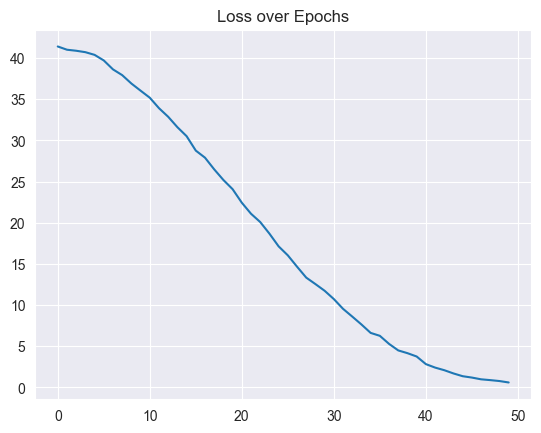

In [27]:
sns.lineplot(history)
plt.title("Loss over Epochs")
plt.show()

50 Epochs seems like a good stopping point for the training as the loss start to settle around that point. 

In [28]:
torch.save(model, 'model.pth')

<h1 align=center>Evaluation</h1>

---

In [29]:
# Refine the evaluation function logic for multi-class classification and compatibility
def evaluate_model_refined(model, test_loader, criterion, device):
    """
    Evaluates the model on the test dataset.

    :param model: The trained model.
    :param test_loader: The DataLoader for the test dataset.
    :param criterion: The loss function used during training.
    :param device: The device to run the model on ('cuda' for GPU, 'cpu' for CPU).
    :return: The average loss and accuracy over the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)


            loss = 0
            for step in range(outputs.shape[1]):
                loss += criterion(outputs[:, step, :], labels[:, step])
            test_loss += loss.item()


            predictions = torch.argmax(outputs, dim=2)
            correct += (predictions == labels).sum().item()
            total += labels.numel()

    # Average loss and overall accuracy
    avg_loss = test_loss / len(test_loader)
    accuracy = (correct / total) * 100


    print("Model Evaluation Results".center(50, "="))
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print("=" * 50)




In [30]:
evaluate_model_refined(model, test_loader, criterion, device)

=============Model Evaluation Results=============
Average Loss: 25.5379
Accuracy: 25.31%


To use the saved weights use the following code:

```
model = torch.load('path/to/weights.pth')
```

---

<h1 align=center>END</h1>